In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("data")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=256).eval().to(device)  # load the extractor
# matcher = LightGlue(features="superpoint", filter_threshold=0.0001, depth_confidence=-1, width_confidence=-1).eval().to(device)

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from imageio import imread
import numpy as np

def load_path_for_pytorch(path, max_side=1000, force_scale=False, verbose=True):

    com_f = max

    x = imread(path)
    s = x.shape

    x = x/255.#-0.5
    xt = x.copy()
    
    if len(s) < 3:
        x = np.stack([x,x,x],2)

    if x.shape[2] > 3:
        x = x[:,:,:3]

    x = x.astype(np.float32)
    x = torch.from_numpy(x).contiguous().permute(2,0,1).contiguous()


    if (com_f(s[:2])>max_side and max_side>0) or force_scale:


        fac = float(max_side)/com_f(s[:2])
        x = F.interpolate(x.unsqueeze(0),( int(s[0]*fac), int(s[1]*fac) ), mode='bilinear', align_corners=False)[0]
        so = s
        s = x.shape

    return x

In [4]:
import os
import torch
from PIL import Image
from torchvision.transforms import Resize, ToTensor

def isolate_green_and_mask_image(image_path, mask_path, long_side, device):
    
    # Load the images
    image = load_path_for_pytorch(image_path, long_side, force_scale=True)
    mask = load_path_for_pytorch(mask_path, long_side, force_scale=True)

    # Convert to tensor
    # to_tensor = ToTensor()
    image = image.to(device)
    mask = mask.to(device)

    # Isolate the green channel and create a binary mask
    # Assuming green regions have higher green values compared to red and blue
    green_channel = mask[1, :, :]
    red_channel = mask[0, :, :]
    blue_channel = mask[2, :, :]
    binary_mask = (green_channel > red_channel) & (green_channel > blue_channel)
    binary_mask = binary_mask.float()

    # Apply the mask
    masked_image = image * binary_mask.unsqueeze(0)

    return masked_image

In [5]:
long_side = 192

# The base directory for your images - adjust this path as necessary
base_dir = images/"mr_us/Case096"

# The name of the original image in the t2 folder
original_image_name = "000.png"

# Extract the base part of the name without the extension
base_name = original_image_name.split('.')[0]

# Construct the pattern to match filenames in the synthetic_us folder
pattern = f"{base_name}-*.png"

# List all files in the synthetic_us directory
synthetic_us_dir = os.path.join(base_dir, "synthetic_us")
all_files = os.listdir(synthetic_us_dir)

# Filter files based on the pattern
matching_files = [file for file in all_files if file.startswith(base_name) and file.endswith(".png")]

print(f"Matching synthetic ultrasound images: {matching_files}")

image0 = load_path_for_pytorch(images / "mr_us/Case096/t2/000.png", long_side,force_scale=True).to(device)
image1 = load_path_for_pytorch(images / "mr_us/Case096/synthetic_us/000-t2_0.3.png", long_side,force_scale=True).to(device)

# Example usage
# masked_image1 = isolate_green_and_mask_image(images/"miccai/styles/207_065_cat5_1.5.png", images/"miccai/mr/207_mr_mask.png", long_side, device)

print(image0.shape)
print(image1.shape)

feats0 = extractor.extract(image0)

feats0 = rbd(feats0)

Matching synthetic ultrasound images: ['000-t2_cet1_flair_1.png', '000-t2_cet1_flair_0.3.png', '000-t2_cet1_flair_0.5.png', '000-t2_flair_0.3.png', '000-flair_0.3.png', '000-t2_cet1_flair_0.7.png', '000-cet1_0.7.png', '000-t2_cet1_1.png', '000-t2_flair_0.7.png', '000-t2_cet1_0.3.png', '000-cet1_flair_0.7.png', '000-cet1_1.png', '000-t2_cet1_0.5.png', '000-cet1_0.5.png', '000-flair_1.png', '000-t2_0.7.png', '000-cet1_flair_0.5.png', '000-t2_flair_1.png', '000-t2_cet1_0.7.png', '000-cet1_flair_1.png', '000-cet1_0.3.png', '000-t2_1.png', '000-flair_0.5.png', '000-t2_0.5.png', '000-t2_flair_0.5.png', '000-flair_0.7.png', '000-cet1_flair_0.3.png', '000-t2_0.3.png']
torch.Size([3, 192, 192])
torch.Size([3, 192, 192])


/tmp/ipykernel_7534/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


In [6]:
def extract_patches(image, keypoints, size=32):
    patches = []

    # If image is in channels-first format, transpose it to channels-last
    if image.shape[0] < image.shape[1] and image.shape[0] < image.shape[2]:
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
    
    for kp in keypoints:
        x, y = int(kp[0]), int(kp[1])
        if x - size // 2 < 0 or y - size // 2 < 0 or x + size // 2 > image.shape[1] or y + size // 2 > image.shape[0]:
            # print(f"Skipping keypoint at ({x}, {y}) - out of bounds")
            continue  # Skip if the patch would be out of image bounds
        patch = image[y - size // 2:y + size // 2, x - size // 2:x + size // 2]
        patches.append(patch)
    return patches

In [7]:
#postfilter approach, filter keypoints after the counter loop using clustering
from collections import defaultdict
from sklearn.cluster import DBSCAN
import numpy as np
import os

# Initialize storage for keypoints
all_style_keypoints = defaultdict(list)
keypoint_counter = defaultdict(int)

# Assuming 'images' is the base directory
rgb_images_dir = images / "mr_us/Case096/synthetic_us/"

# Check if the directory exists
if not rgb_images_dir.exists():
    print(f"Directory {rgb_images_dir} not found")
    exit()

# image0 = load_image(images / "real" / "anchor.png")
# feats0 = extractor.extract(image0)
# feats0 = rbd(feats0)
kpts = feats0["keypoints"]

In [8]:
kpts = kpts.cpu().numpy()
print(len(kpts))
print(kpts)

256
[[ 59.96875 113.21875]
 [125.96875 164.96875]
 [128.03125 127.84375]
 [156.53125  73.84375]
 [ 59.96875  71.96875]
 [ 47.03125  86.03125]
 [ 59.96875 116.78125]
 [ 70.09375  56.96875]
 [ 71.03125  92.03125]
 [105.15625  50.21875]
 [ 53.96875 110.21875]
 [ 39.90625  84.90625]
 [141.15625 133.84375]
 [134.96875 129.90625]
 [ 62.03125  74.03125]
 [153.34375  59.59375]
 [113.03125  92.21875]
 [ 83.03125 119.03125]
 [ 38.96875  74.78125]
 [136.84375  65.96875]
 [150.15625 150.34375]
 [153.34375 139.28125]
 [146.03125  53.03125]
 [119.03125 116.96875]
 [ 83.96875 104.21875]
 [ 66.15625 146.03125]
 [ 74.96875 133.46875]
 [101.03125 155.78125]
 [150.34375  47.59375]
 [146.96875 125.96875]
 [132.15625 124.84375]
 [110.03125  89.03125]
 [154.09375 135.34375]
 [ 83.78125 128.96875]
 [147.34375 159.34375]
 [150.90625 146.40625]
 [116.78125 138.15625]
 [147.53125  39.71875]
 [ 32.59375 122.59375]
 [ 62.03125  92.03125]
 [ 86.78125 112.65625]
 [ 77.78125  80.03125]
 [ 35.59375 115.84375]
 [131.0

In [9]:
# Cluster keypoints using DBSCAN
clustering = DBSCAN(eps=5, min_samples=1).fit(kpts)

# Get cluster centers (average of points in each cluster)
cluster_centers = []
for label in set(clustering.labels_):
    points_in_cluster = kpts[clustering.labels_ == label]
    cluster_center = points_in_cluster.mean(axis=0)
    cluster_centers.append(cluster_center)

# cluster_centers now contains your merged keypoints
print(len(cluster_centers))

132


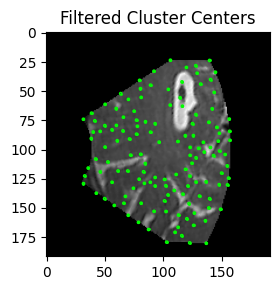

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Load the original MR image for plotting
# original_mr_image_path = 'data/real/anchor.png'  # Update this path if needed
# original_mr_image = Image.open(original_mr_image_path)

# # Convert the image to a NumPy array for plotting
# original_mr_image_np = np.array(original_mr_image)

original_mr_image_np = image0.cpu().numpy()

# If image is in channels-first format, transpose it to channels-last
if original_mr_image_np.shape[0] < original_mr_image_np.shape[1] and original_mr_image_np.shape[0] < original_mr_image_np.shape[2]:
    original_mr_image_np = original_mr_image_np.transpose(1, 2, 0)  # Convert to (H, W, C)



# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

# Plot the original MR image with postfiltered cluster_centers
axes.imshow(original_mr_image_np)
for center in cluster_centers:
    x, y = center
    axes.scatter(x, y, c='lime', s=1)  # green point for each filtered center
    axes.add_patch(patches.Circle((x, y), radius=1, fill=False, edgecolor='lime', linewidth=1))
axes.set_title("Filtered Cluster Centers")

plt.tight_layout()
plt.show()


In [11]:
def extract_pos_neg_patches(image, keypoints, size=64, shift=50):
    pos_patches = []
    neg_patches = []

    # If image is in channels-first format, transpose it to channels-last
    if image.shape[0] < image.shape[1] and image.shape[0] < image.shape[2]:
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
    
    for kp in keypoints:
        x, y = int(kp[0]), int(kp[1])
        if x - size // 2 < 0 or y - size // 2 < 0 or x + size // 2 > image.shape[1] or y + size // 2 > image.shape[0]:
            # print(f"Skipping keypoint at ({x}, {y}) - out of bounds")
            continue  # Skip if the patch would be out of image bounds
        postive_patch = image[y - size // 2:y + size // 2, x - size // 2:x + size // 2]
        pos_patches.append(postive_patch)
        # Determine new x and y, ensuring they stay within the image boundaries
        new_x = x + shift if x + shift < image.shape[1] - size // 2 else x - shift
        new_y = y + shift if y + shift < image.shape[0] - size // 2 else y - shift
        # Ensure new_x and new_y are within bounds
        new_x = max(min(new_x, image.shape[1] - size // 2), size // 2)
        new_y = max(min(new_y, image.shape[0] - size // 2), size // 2)

        # print(new_y, new_x)
        
        negative_patch = image[new_y - size // 2:new_y + size // 2, new_x - size // 2:new_x + size // 2]
        neg_patches.append(negative_patch)
        
    return pos_patches, neg_patches

In [12]:
def add_rotations_of_pos_as_neg(base_mr_patches, positive_patches):

    negative_pairs = []
    
    for base_patch, positive_patch in zip(base_mr_patches, positive_patches):
        # Rotate the positive patch and add each rotation to negative patches
        for angle in range(90, 270, 90):
            rotated_patch = rotate(positive_patch, angle, resize=False, mode='edge')
            negative_pairs.append((base_patch, rotated_patch))
    
    return negative_pairs

In [14]:
import os

size = 64
shift = 50

# Directory paths
t2_dir = os.path.join(base_dir, "t2")
synthetic_us_dir = os.path.join(base_dir, "synthetic_us")

# Initialize lists for positive and negative patch pairs across all images
all_positive_patch_pairs = []
all_negative_patch_pairs = []

t2_image = "039.png"

# Ensure we're only processing images
if t2_image.endswith('.png'):
    base_name = t2_image.split('.')[0]
    pattern = f"{base_name}-*.png"
    
    # Load the t2 image
    t2_image_path = os.path.join(t2_dir, t2_image)
    t2_image_data = load_path_for_pytorch(t2_image_path, long_side, force_scale=True).to(device)
    
    # Extract features and keypoints from the t2 image
    feats_t2 = extractor.extract(t2_image_data)
    feats_t2 = rbd(feats_t2)
    kpts_t2 = feats_t2["keypoints"]
    
    # Cluster keypoints
    clustering_t2 = DBSCAN(eps=5, min_samples=1).fit(kpts_t2.cpu().numpy())
    cluster_centers_t2 = [kpts_t2[clustering_t2.labels_ == label].mean(axis=0) for label in set(clustering_t2.labels_)]
    
    # Extract patches from the base MR image
    base_mr_patches = extract_patches(t2_image_data.cpu().numpy(), cluster_centers_t2, size=size)
    
    # Find all matching styled images
    matching_files = [file for file in os.listdir(synthetic_us_dir) if file.startswith(base_name) and file.endswith(".png")]
    
    # Process each matching styled image
    for styled_image_name in matching_files:
        styled_image_path = os.path.join(synthetic_us_dir, styled_image_name)
        styled_image_data = load_path_for_pytorch(styled_image_path, long_side, force_scale=True).to(device).cpu().numpy()
        
        # Extract positive and negative patches
        pos_styled_patches, neg_styled_patches = extract_pos_neg_patches(styled_image_data, cluster_centers_t2, size=size, shift=shift)
        
        # Create patch pairs
        for base_patch, pos_patch in zip(base_mr_patches, pos_styled_patches):
            all_positive_patch_pairs.append((base_patch, pos_patch))
        for base_patch, neg_patch in zip(base_mr_patches, neg_styled_patches):
            all_negative_patch_pairs.append((base_patch, neg_patch))

# Now, all_positive_patch_pairs and all_negative_patch_pairs contain pairs of patches for all images

/tmp/ipykernel_7534/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_7534/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


In [15]:
print(len(all_positive_patch_pairs))

2772


In [16]:
print(len(all_negative_patch_pairs))

2772


In [17]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

# from siamese.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [18]:
# # Split the dataset into train and test
def split_dataset(patches, labels, train_size=0.8):
    dataset_size = len(patches)
    indices = list(range(dataset_size))
    split = int(np.floor(train_size * dataset_size))

    np.random.shuffle(indices)

    train_indices, test_indices = indices[:split], indices[split:]
    train_patches = [patches[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    test_patches = [patches[i] for i in test_indices]
    test_labels = [labels[i] for i in test_indices]

    return train_patches, train_labels, test_patches, test_labels

Prepare dataset using torch dataloader

In [19]:
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import torch

class SiamesePatchDataset(Dataset):
    def __init__(self, patches, labels, train=True):
        # Store patches and labels as lists to allow modification
        self.patches = list(patches)
        self.labels = list(labels)
        self.train = train

        # Define transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0), std=(1))
        ])

    def __getitem__(self, index):
        img1, img2 = self.patches[index]
        label = self.labels[index]

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        return (img1, img2), torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.patches)

    def update_label(self, index, new_label):
        self.labels[index] = new_label


def create_siamese_dataset(positive_patches, negative_patches):
    """
    Combines positive and negative patches into a single dataset with correct labels.
    """
    # Label positive patches as 1 and negative patches as 0
    positive_labels = [1] * len(positive_patches)
    negative_labels = [0] * len(negative_patches)

    # Combine patches and labels
    all_patches = positive_patches + negative_patches
    all_labels = positive_labels + negative_labels

    # Shuffle the combined dataset to mix positive and negative patches
    combined = list(zip(all_patches, all_labels))
    np.random.shuffle(combined)
    shuffled_patches, shuffled_labels = zip(*combined)

    return list(all_patches), list(all_labels)

# Create the dataset with correctly aligned patches and labels
positive_patches = [(patch1, patch2) for patch1, patch2 in all_positive_patch_pairs]
negative_patches = [(patch1, patch2) for patch1, patch2 in all_negative_patch_pairs]

shuffled_patches, shuffled_labels = create_siamese_dataset(positive_patches, negative_patches)

# Now use shuffled_patches and shuffled_labels to create your train and test datasets
train_patches, train_labels, test_patches, test_labels = split_dataset(shuffled_patches, shuffled_labels)

# Create train and test datasets
train_dataset = SiamesePatchDataset(train_patches, train_labels, train=True)
test_dataset = SiamesePatchDataset(test_patches, test_labels, train=False)


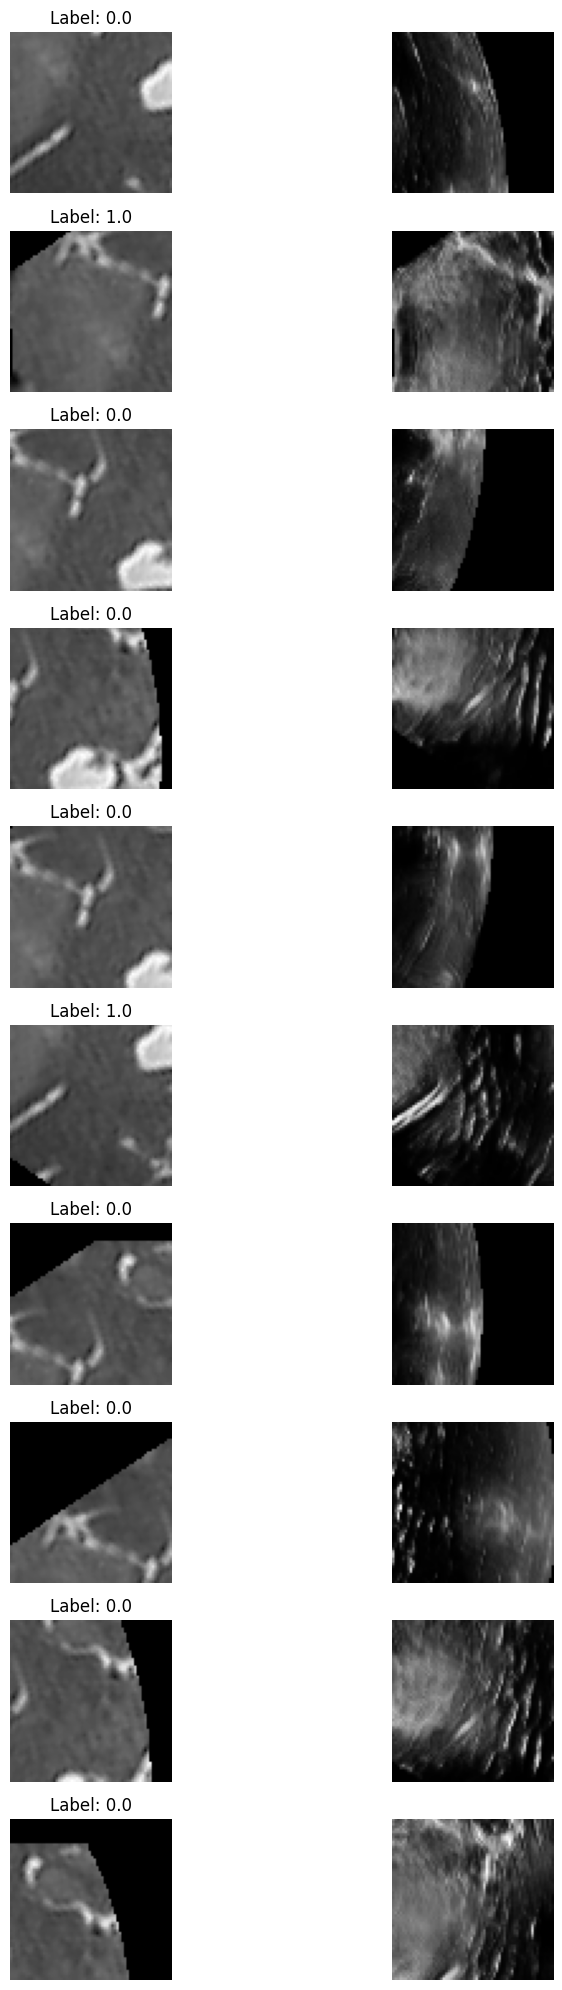

In [20]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def visualize_dataset(dataset, num_samples=10):
    """
    Visualize patch pairs and their labels from the dataset.

    Args:
        dataset (SiamesePatchDataset): The dataset to visualize.
        num_samples (int): Number of samples to visualize.
    """
    # Adjust number of samples if the dataset is smaller
    num_samples = min(num_samples, len(dataset))

    # Create subplots
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

    for i in range(num_samples):
        # Get a sample from the dataset
        (patch1, patch2), label  = dataset[i]

        # print(dataset[i])

        # Convert patches back to PIL Image for display
        patch1 = to_pil_image(patch1)
        patch2 = to_pil_image(patch2)

        # Display patch1
        axs[i, 0].imshow(patch1)
        axs[i, 0].axis('off')

        # Display patch2
        axs[i, 1].imshow(patch2)
        axs[i, 1].axis('off')

        # Set title with label
        axs[i, 0].set_title(f'Label: {label.item()}')
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_dataset(train_dataset, num_samples=10)


In [21]:
import tkinter as tk
from tkinter import messagebox
from PIL import ImageTk, Image
from torchvision.transforms.functional import to_pil_image

class PatchLabelingApp:
    def __init__(self, dataset):
        self.dataset = dataset
        self.index = 0

        # Set up the main window
        self.window = tk.Tk()
        self.window.title("Patch Labeling Tool")
        self.window.protocol("WM_DELETE_WINDOW", self.on_closing)  # Handle window close event
        self.window.bind('<Left>', lambda e: self.prev_patch())  # Bind left arrow key
        self.window.bind('<Right>', lambda e: self.next_patch())  # Bind right arrow key
        self.window.bind('p', lambda e: self.update_label(1))  # Bind 'p' key
        self.window.bind('n', lambda e: self.update_label(0))  # Bind 'n' key
        self.window.bind('d', lambda e: self.remove_patch())  # Bind 'd' key

        # Text input field for jumping to an index
        self.index_entry = tk.Entry(self.window)
        self.index_entry.pack()
        jump_button = tk.Button(self.window, text="Jump to Index", command=self.jump_to_index)
        jump_button.pack()

        # Display the first patch pair
        self.display_patches()

        # Navigation buttons
        next_button = tk.Button(self.window, text="Next", command=self.next_patch)
        next_button.pack(side=tk.LEFT)
        prev_button = tk.Button(self.window, text="Previous", command=self.prev_patch)
        prev_button.pack(side=tk.LEFT)

        # Label update buttons
        positive_button = tk.Button(self.window, text="Set Positive", command=lambda: self.update_label(1))
        positive_button.pack(side=tk.LEFT)
        negative_button = tk.Button(self.window, text="Set Negative", command=lambda: self.update_label(0))
        negative_button.pack(side=tk.LEFT)

        self.window.mainloop()

    def display_patches(self):
        # Check if index is within bounds
        if self.index < len(self.dataset):
            patch1, patch2 = self.dataset[self.index][0]
            patch1 = ImageTk.PhotoImage(image=to_pil_image(patch1))
            patch2 = ImageTk.PhotoImage(image=to_pil_image(patch2))
            label = self.dataset[self.index][1].item()

            # Clear previous images and labels
            for widget in self.window.winfo_children():
                if isinstance(widget, tk.Label) or isinstance(widget, tk.Canvas):
                    widget.destroy()

            # Display images
            self.label1 = tk.Label(self.window, image=patch1)
            self.label1.image = patch1
            self.label1.pack(side=tk.LEFT)
            self.label2 = tk.Label(self.window, image=patch2)
            self.label2.image = patch2
            self.label2.pack(side=tk.LEFT)

            # Display label and index
            self.label_text = tk.Label(self.window, text=f"Index: {self.index}, Current Label: {'Positive' if label == 1 else 'Negative'}")
            self.label_text.pack()

    def jump_to_index(self):
        try:
            new_index = int(self.index_entry.get())
            if 0 <= new_index < len(self.dataset):
                self.index = new_index
                self.display_patches()
            else:
                messagebox.showerror("Error", "Index out of range.")
        except ValueError:
            messagebox.showerror("Error", "Invalid index value.")

    def next_patch(self):
        if self.index < len(self.dataset) - 1:
            self.index += 1
            self.display_patches()

    def prev_patch(self):
        if self.index > 0:
            self.index -= 1
            self.display_patches()

    def update_label(self, new_label):
        self.dataset.update_label(self.index, new_label)
        self.display_patches()

    def remove_patch(self):
        if len(self.dataset) > 0 and self.index < len(self.dataset):
            del self.dataset[self.index]  # Remove the current patch pair
            if self.index >= len(self.dataset) and len(self.dataset) > 0:
                self.index -= 1  # Adjust index if it's now out of range
            self.display_patches()

    def on_closing(self):
        if messagebox.askokcancel("Quit", "Do you want to quit?"):
            self.window.destroy()

# Example usage
# app = PatchLabelingApp(train_dataset)
# Make sure to replace 'train_dataset' with the actual dataset object you're using

In [22]:
import pickle

def save_dataset(dataset, filename):
    with open(filename, 'wb') as file:
        pickle.dump({'patches': dataset.patches, 'labels': dataset.labels}, file)

def load_dataset(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return SiamesePatchDataset(data['patches'], data['labels'], train=True)

In [23]:
# train_dataset = load_dataset('patches_datasets/lightglue2048-flann/siamese_patches_train_dataset.pkl')
# test_dataset = load_dataset('patches_datasets/lightglue2048-flann/siamese_patches_test_dataset.pkl')

# train_dataset = load_dataset('siamese_patches_train_dataset.pkl')
# test_dataset = load_dataset('siamese_patches_test_dataset.pkl')

# save_dataset(train_dataset, '100k_patches_ves_rot_train_dataset_128.pkl')
# save_dataset(test_dataset, '100k_patches_ves_rot_test_dataset_128.pkl')

In [24]:
len(train_dataset)

4435

In [25]:
len(test_dataset)

1109

In [26]:
# app = PatchLabelingApp(train_dataset)

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [28]:
class UNet(nn.Module):
    def __init__(self, output_size=128):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)  # Output: 64x64x128
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 32x32x256
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16x256
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: 8x8x512
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)  # Output: 4x4x1024
        # Decoder with dense layers for embedding
        self.fc1 = nn.Linear(512 * 2 * 2, output_size)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = self.max_pool(x)
        x = F.relu(self.enc_conv3(x))
        x = self.max_pool(x)
        x = F.relu(self.enc_conv4(x))

        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)

        # Decoder with dense layers for embedding
        x = self.fc1(x)

        return x

# class UNet(nn.Module):
#     def __init__(self, output_size=128):
#         super(UNet, self).__init__()

#         self.network = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             #256x256x64
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding='valid'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=128),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #128x128x128
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding='valid'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=256),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #64x64x256
#             nn.Conv2d(256, 512, kernel_size=3, stride=2, padding='valid'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #32x32x512
#             nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding="valid"),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=1024),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #16x16x1024
#             nn.Conv2d(1024, 512, kernel_size=3, stride=2, padding="valid"),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #8x8x512
#             nn.Conv2d(512, 256, kernel_size=3, padding="same"),
#             nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #4x4x256
#             # nn.Conv2d(256, 128, kernel_size=2, padding="same"),
#             # nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             # 2x2x128 
#             nn.Flatten(),
#             nn.Linear(256*3*3, 128)
#             # nn.Conv2d(128, 128, kernel_size=1, stride=1),
#             # nn.Sigmoid(),
#         )

# class UNet(nn.Module):
#     def __init__(self, output_size=128):
#         super(UNet, self).__init__()

#         self.network = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             #256x256x64
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=128),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #128x128x128
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=256),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #64x64x256
#             nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #32x32x512
#             nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=1024),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #16x16x1024
#             nn.Conv2d(1024, 512, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #8x8x512
#             nn.Conv2d(512, 256, kernel_size=3, padding="same"),
#             nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #4x4x256
#             # nn.Conv2d(256, 128, kernel_size=2, padding="same"),
#             # nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             # 2x2x128 
#             nn.Flatten(),
#             nn.Linear(256*4*4, 128)
#             # nn.Conv2d(128, 128, kernel_size=1, stride=1),
#             # nn.Sigmoid(),
#         )

    # def forward(self, x):
    #     x = self.network(x)
    #     return x

In [29]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.get_embedding(x1)
        output2 = self.get_embedding(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)


In [30]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss with hard negative mining.
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise.
    Also considers hard negatives if provided.
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, hard_negatives=None, size_average=True):
        # Calculate distances for positive pairs
        positive_distances = (output2 - output1).pow(2).sum(1)
        positive_losses = 0.5 * target.float() * positive_distances

        # Calculate distances for negative pairs
        negative_distances = (output2 - output1).pow(2).sum(1)
        negative_losses = 0.5 * (1 - target).float() * F.relu(self.margin - (negative_distances + self.eps).sqrt()).pow(2)

        # If hard negatives are provided, calculate the distance and replace negative losses
        if hard_negatives is not None:
            hard_negative_distances = (output1 - hard_negatives).pow(2).sum(1)
            hard_negative_losses = 0.5 * (1 - target).float() * F.relu(self.margin - (hard_negative_distances + self.eps).sqrt()).pow(2)
            negative_losses = torch.where(hard_negative_distances < negative_distances, hard_negative_losses, negative_losses)

        total_loss = positive_losses + negative_losses

        return total_loss.mean() if size_average else total_loss.sum()

In [31]:
from torch.utils.data import DataLoader

def calculate_accuracy(threshold, distances, targets):
    predicted = (distances < threshold).float()
    correct = (predicted == targets).float().sum()
    return correct / targets.size(0)

# Prepare the data loaders
# You can adjust the threshold based on your validation set
similarity_threshold = 0.5
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
from torch.optim.lr_scheduler import StepLR

# Assuming 'cuda' is available, otherwise use 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
embedding_net = UNet().to(device)
model = SiameseNetwork(embedding_net).to(device)
loss_fn = ContrastiveLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

cuda


In [33]:
from torchvision.transforms import functional as TF

def rotate_image(image, angle):
    return TF.rotate(image, angle)

In [35]:
n_epochs = 20  # Number of epochs
log_interval = 10  # Interval for printing log

for epoch in range(n_epochs):
    torch.set_grad_enabled(True)
    model.train()  # Set the model to training mode
    total_loss = 0.0
    total_accuracy = 0.0

    for batch_idx, ((img1, img2), target) in enumerate(train_loader):
        img1, img2, target = img1.to(device), img2.to(device), target.to(device)

        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        
        # Hard negative mining according to Robinson et al 2021 ICLR Paper
        anchor_embeddings = output1
        other_embeddings = output2
        # Compute pairwise distances between anchor and other samples
        pairwise_dist = torch.cdist(anchor_embeddings, other_embeddings)
        # Mask for excluding positive pairs in hard negative mining
        mask = target.view(-1, 1).expand(pairwise_dist.size()).bool()
        pairwise_dist.masked_fill_(mask, float('inf'))
        # Find hard negatives (closest negative samples)
        hard_negatives_indices = torch.argmin(pairwise_dist, dim=1)
        # print(hard_negatives_indices)
        hard_negatives = other_embeddings[hard_negatives_indices]
        
        # Compute distance and accuracy
        distance = F.pairwise_distance(output1, output2)
        # print(distance)
        total_accuracy += calculate_accuracy(similarity_threshold, distance, target)


        # loss = loss_fn(output1, output2, target)
        # Compute loss with hard negatives
        loss = loss_fn(output1, output2, target, hard_negatives)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    print(f'Epoch: {epoch}, Average Loss: {average_loss}, Average Training Accuracy: {average_accuracy}')

    # Update learning rate
    scheduler.step()

    # Validation step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0
        for (img1, img2), target in test_loader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            output1, output2 = model(img1, img2)
            val_loss += loss_fn(output1, output2, target).item()

        average_val_loss = val_loss / len(test_loader)
        print(f'Validation Loss: {average_val_loss}')

Epoch: 0, Batch: 0, Loss: 0.10882233083248138
Epoch: 0, Batch: 10, Loss: 0.1209966391324997
Epoch: 0, Average Loss: 0.11368342116475105, Average Training Accuracy: 0.9113302230834961
Validation Loss: 0.05885628834366798
Epoch: 1, Batch: 0, Loss: 0.1132168173789978
Epoch: 1, Batch: 10, Loss: 0.11033175140619278
Epoch: 1, Average Loss: 0.11369973255528344, Average Training Accuracy: 0.8584311604499817
Validation Loss: 0.05836772248148918
Epoch: 2, Batch: 0, Loss: 0.1110684871673584
Epoch: 2, Batch: 10, Loss: 0.10802674293518066
Epoch: 2, Average Loss: 0.11257154825660917, Average Training Accuracy: 0.9219455718994141
Validation Loss: 0.05659635066986084
Epoch: 3, Batch: 0, Loss: 0.11368405818939209
Epoch: 3, Batch: 10, Loss: 0.11528120934963226
Epoch: 3, Average Loss: 0.11279119675358136, Average Training Accuracy: 0.9064826965332031
Validation Loss: 0.060675562173128125
Epoch: 4, Batch: 0, Loss: 0.11648440361022949
Epoch: 4, Batch: 10, Loss: 0.10840208828449249
Epoch: 4, Average Loss: 0

In [ ]:
# n_epochs = 20  # Number of epochs
# log_interval = 10  # Interval for printing log
# rotation_angles = [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345]  # Define rotation angles

# for epoch in range(n_epochs):
#     torch.set_grad_enabled(True)
#     model.train()  # Set the model to training mode
#     total_loss = 0.0
#     total_accuracy = 0.0

#     for batch_idx, ((img1, img2), target) in enumerate(train_loader):
#         img1, img2, target = img1.to(device), img2.to(device), target.to(device)

#         optimizer.zero_grad()
#         output1, output2 = model(img1, img2)
        
#         # Hard negative mining according to Robinson et al 2021 ICLR Paper
#         anchor_embeddings = output1
#         other_embeddings = output2
#         # Compute pairwise distances between anchor and other samples
#         pairwise_dist = torch.cdist(anchor_embeddings, other_embeddings)
#         # Mask for excluding positive pairs in hard negative mining
#         mask = target.view(-1, 1).expand(pairwise_dist.size()).bool()
#         pairwise_dist.masked_fill_(mask, float('inf'))
#         # Find hard negatives (closest negative samples)
#         hard_negatives_indices = torch.argmin(pairwise_dist, dim=1)
#         # print(hard_negatives_indices)
#         hard_negatives = other_embeddings[hard_negatives_indices]
        
#         # Compute distance and accuracy
#         distance = F.pairwise_distance(output1, output2)
#         # print(distance)
#         total_accuracy += calculate_accuracy(similarity_threshold, distance, target)


#         # loss = loss_fn(output1, output2, target)
#         # Compute loss with hard negatives
#         loss = loss_fn(output1, output2, target, hard_negatives)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         # Iterate over each item in the batch
#         for i in range(target.size(0)):  # target.size(0) gives the batch size
#             # Check if the current pair is a positive pair
#             if target[i].item() == 1:  # Assuming 1 indicates a positive pair
#                 for angle in rotation_angles:
#                     rotated_img2 = rotate_image(img2[i], angle).unsqueeze(0).to(device)
#                     rotated_target = torch.tensor([0], dtype=target.dtype).to(device)  # Label for negative pairs

#                     # Forward pass with rotated image
#                     _, output_rotated = model(img1[i].unsqueeze(0), rotated_img2)
#                     rotated_loss = loss_fn(output1[i].unsqueeze(0), output_rotated, rotated_target)
#                     total_loss += rotated_loss.item()

#         # # Generate rotations for positive pairs
#         # if target.item() == 1:  # Assuming 1 is the label for positive pairs
#         #     optimizer.zero_grad()
#         #     for angle in rotation_angles:
#         #         rotated_img2 = rotate_image(img2, angle).to(device)
#         #         rotated_target = torch.tensor([0]).to(device)  # Label for negative pairs

#         #         # Forward pass with rotated image
#         #         _, output_rotated = model(img1, rotated_img2)
#         #         # Calculate loss and accuracy for rotated pairs
#         #         rotated_distance = F.pairwise_distance(output1, output_rotated)
#         #         total_accuracy += calculate_accuracy(similarity_threshold, rotated_distance, rotated_target)
#         #         rotated_loss = loss_fn(output1, output_rotated, rotated_target)
#         #         total_loss += rotated_loss.item()

#         if batch_idx % log_interval == 0:
#             print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

#     average_loss = total_loss / len(train_loader)
#     average_accuracy = total_accuracy / len(train_loader)
#     print(f'Epoch: {epoch}, Average Loss: {average_loss}, Average Training Accuracy: {average_accuracy}')

#     # Update learning rate
#     scheduler.step()

#     # Validation step
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         val_loss = 0
#         for (img1, img2), target in test_loader:
#             img1, img2, target = img1.to(device), img2.to(device), target.to(device)
#             output1, output2 = model(img1, img2)
#             val_loss += loss_fn(output1, output2, target).item()

#         average_val_loss = val_loss / len(test_loader)
#         print(f'Validation Loss: {average_val_loss}')

In [ ]:
# from torchviz import make_dot

# x1 = torch.randn(1, 3, 64, 64).to(device)  # Example input (adjust the size according to your model)
# x2 = torch.randn(1, 3, 64, 64).to(device)  # Example input (adjust the size according to your model)
# # y = embedding_net(x1)
# # dot = make_dot(y, params=dict(embedding_net.named_parameters()))
# # dot.render('embedding_model_graph', format='png')  # This will save the graph as a PNG file

# y = model(x1, x2)
# make_dot(y, params=dict(model.named_parameters()))
# # dot.render('model_graph', format='png')  # This will save the graph as a PNG file

In [ ]:


# input_names = ["Image Patch"]
# output_names = ["Output Vector"]

# torch.onnx.export(embedding_net, x1, "model.onnx", input_names=input_names, output_names=output_names)

In [36]:
# Assuming 'model' is your trained model
model_state_file = "model_weights-mr_us-64_256-slice39.pth"

# Save the model state
torch.save(model.state_dict(), model_state_file)

In [ ]:
# model_state_file = "model_weights_real_mr_scl.pth"

# model.load_state_dict(torch.load(model_state_file, map_location=torch.device('cpu')))

# model.eval()